# Precipitation Frequency Table

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each duration and a sheet with the NOAA Atlas 14 volume and region numbers. For each duration, the sheet contains a table with area-averaged precipitation and confidence limits. 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*

### Parameters: 

#### Papermill (site specific):

In [2]:
## Filenames:
Project_Area = 'Sacramento'
Pluvial_Model = 'P02'          
BCN = 'D15'  

polygon = 'PluvialDomain_V5.shp' # Name
filter_field = 'Pluvial_Do'          # Attribute with in the vector polygon used for data selection
select_data = BCN              # Value within the filter_field used for data selection
gdf_slice_column = 'Pluvial_Do'       # Column within the vector polygon to plot

brute_force_projection = '+proj=lcc +lat_1=39.83333333333334 +lat_2=38.33333333333334 +lat_0=37.66666666666666 +lon_0=-122 +x_0=2000000.0001016 +y_0=500000.0001016001 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=us-ft +no_defs'

## Paths:
root_dir =  pl.Path(r'C:\Users\sputnam\Desktop\PFRA_Production\Sacramento')
#root_dir = pl.Path(os.getcwd())
datarepository_dir = pl.Path(os.getcwd())/'DataRepository'
#datarepository_dir = root_dir/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'

##### Convert all paths to objects:

In [3]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
noaa_data_crs = {'init':'epsg:4326'} 

durations = ['06h', '12h', '24h', '04d'] 
dur_names = ['6hr', '12hr', '24hr', '96hr']

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [5]:
gdf = gpd.GeoDataFrame.from_file(polygon_dir)

gdf.head(2)

,OBJECTID,HUC12,NAME_1,PTS,Company,cordinate,area,Model_Area,Modeler_Na,DA,Pluvial_Do,Pluvial_Mo,geometry
0,11,180201630302,Tule Canal-Toe Drain,STARRII,Dewberry,"PROJCS[""North_America_Albers_Equal_Area_Conic""...",200000.0,1,Seth Bradley,82.709280,D14,P02,"POLYGON ((6667253.745535955 2008677.719047442,..."
1,23,180201110302,Arcade Creek,STARRII,Dewberry,"PROJCS[""North_America_Albers_Equal_Area_Conic""...",70000.0,7,Matt Deshotel,48.183988,D26,P01,"POLYGON ((6737850.961454228 1997428.366811171,..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [6]:
print('Original Coordinate Reference System:', gdf.crs)
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))

Original Coordinate Reference System: {'init': 'epsg:2226'}
Error: Setting projection as +proj=lcc +lat_1=39.83333333333334 +lat_2=38.33333333333334 +lat_0=37.66666666666666 +lon_0=-122 +x_0=2000000.0001016 +y_0=500000.0001016001 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=us-ft +no_defs


### Extract the area of interest, reproject, and plot:

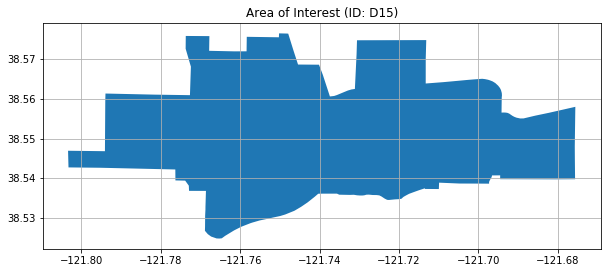

In [7]:
gdf = gdf.loc[gdf[filter_field] == select_data].copy()
    
gdf.crs = vector_crs_prj

geo_df = gdf.to_crs(crs = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, gdf_slice_column)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           6
Region           5
Percent_area     100.0


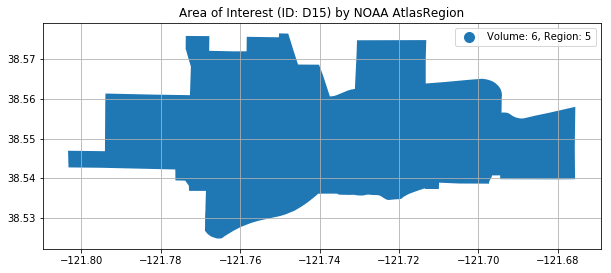

In [8]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [9]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: sw


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [10]:
noaa_url = 'ftp://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

30 files found for 06h
30 files found for 12h
30 files found for 24h
30 files found for 04d


### Iterate through zip files and build a table:

In [11]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 sw1000yr06ha.zip
1 sw1000yr06hal.zip
2 sw1000yr06hau.zip
3 sw100yr06ha.zip
4 sw100yr06hal.zip
5 sw100yr06hau.zip
6 sw10yr06ha.zip
7 sw10yr06hal.zip
8 sw10yr06hau.zip
9 sw1yr06ha.zip
10 sw1yr06hal.zip
11 sw1yr06hau.zip
12 sw200yr06ha.zip
13 sw200yr06hal.zip
14 sw200yr06hau.zip
15 sw25yr06ha.zip
16 sw25yr06hal.zip
17 sw25yr06hau.zip
18 sw2yr06ha.zip
19 sw2yr06hal.zip
20 sw2yr06hau.zip
21 sw500yr06ha.zip
22 sw500yr06hal.zip
23 sw500yr06hau.zip
24 sw50yr06ha.zip
25 sw50yr06hal.zip
26 sw50yr06hau.zip
27 sw5yr06ha.zip
28 sw5yr06hal.zip
29 sw5yr06hau.zip
30 sw1000yr12ha.zip
31 sw1000yr12hal.zip
32 sw1000yr12hau.zip
33 sw100yr12ha.zip
34 sw100yr12hal.zip
35 sw100yr12hau.zip
36 sw10yr12ha.zip
37 sw10yr12hal.zip
38 sw10yr12hau.zip
39 sw1yr12ha.zip
40 sw1yr12hal.zip
41 sw1yr12hau.zip
42 sw200yr12ha.zip
43 sw200yr12hal.zip
44 sw200yr12hau.zip
45 sw25yr12ha.zip
46 sw25yr12hal.zip
47 sw25yr12hau.zip
48 sw2yr12ha.zip
49 sw2yr12hal.zip
50 sw2yr12hau.zip
51 sw500yr12ha.zip
52 sw500yr12hal.zip
53 sw50

,TR,duration,region,statistic,value
0,1000,06h,sw,Expected Value,4.012479
1,1000,06h,sw,Lower (90%),2.841729
2,1000,06h,sw,Upper (90%),5.722854
3,100,06h,sw,Expected Value,2.828250
4,100,06h,sw,Lower (90%),2.268729


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [12]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

In [13]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(durations):
    table = pd.pivot_table(df[df['duration'] == d], values = 'value', index=['TR'], columns=['statistic'])
    table.index.name = 'Tr'
    table.columns.name = None
    table = table.sort_values(by = ['Expected Value'])
    table.to_excel(writer, sheet_name = 'AreaDepths_{}'.format(dur_names[i]))
    print(table)

metadata = pd.DataFrame.from_dict([volume_dict])
metadata['AOI'] = str(filter_field) + '_' + str(select_data)
metadata = metadata.set_index('AOI')
metadata.to_excel(writer, sheet_name = 'NOAA_Atlas_MetaData')
print('\nNOAA_Atlas_MetaData:')
display(metadata)
    
writer.save()

      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           0.996583     0.893458     1.123021
2           1.234750     1.105063     1.393292
5           1.556979     1.388979     1.762979
10          1.827813     1.614375     2.090667
25          2.208563     1.872417     2.631604
50          2.511500     2.075333     3.069958
100         2.828250     2.268729     3.561208
200         3.164104     2.453792     4.120875
500         3.634729     2.682021     4.975854
1000        4.012479     2.841729     5.722854
      Expected Value  Lower (90%)  Upper (90%)
Tr                                            
1           1.336938     1.198438     1.506458
2           1.672688     1.497167     1.887500
5           2.120521     1.891667     2.400979
10          2.491396     2.200417     2.849542
25          3.004583     2.547188     3.579938
50          3.406292     2.814854     4.163750
100         3.820625     3.064896     4.810833
200         4

,Volume,Region,Percent_area
AOI,,,
Pluvial_Do_D15,6,5,100.0


---